In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures

In [3]:
df = pd.read_csv('NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/nips4b_birdchallenge_train_labels.csv')
# df

In [4]:
df = df.drop('Unnamed: 3', 1)
df = df.drop('Unnamed: 1', 1)
df.fillna(0, inplace=True)
# df

/var/folders/km/7_v861mx0cb9fp42nvllkmt00000gn/T/ipykernel_3923/4237743302.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Unnamed: 3', 1)
/var/folders/km/7_v861mx0cb9fp42nvllkmt00000gn/T/ipykernel_3923/4237743302.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Unnamed: 1', 1)


In [5]:
a = df.iloc[1,:2].values
b = df.iloc[0,2:].values
c = np.concatenate((a, b), axis=0)
columns = c[1:]

In [6]:
df = df.drop([0,1,689])
df.reset_index(inplace=True)
df = df.drop('index', 1)

/var/folders/km/7_v861mx0cb9fp42nvllkmt00000gn/T/ipykernel_3923/1129736625.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('index', 1)


In [7]:
df.columns = c

In [8]:
df.Filename = ['./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/'+f for f in df.Filename]
df.head()

,Filename,Empty,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,...,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
0,./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/n...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/n...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/n...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/n...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/n...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [9]:
cols=[i for i in df.columns if i not in ["Filename"]]
for col in cols:
    df[col]=pd.to_numeric(df[col])

In [10]:
# helper function for displaying a sample as an image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
def show_tensor(sample):
    plt.imshow((sample['X'][0,:,:]/2+0.5)*-1,cmap='Greys',vmin=-1,vmax=0)
    plt.show()

In [11]:
# ef = df.set_index('Filename')
# for c in ef.columns:
#     print("---- %s ---" % c)
#     print(ef[c].value_counts())

## Binary classification

In [12]:
from opensoundscape.annotations import categorical_to_one_hot
one_hot_labels, classes = categorical_to_one_hot(df[['Empty']].values)
labels = pd.DataFrame(index=df['Filename'],data=one_hot_labels,columns=classes)
labels.rename(columns={0: "non-empty", 1: "empty"}, inplace=True)
labels['empty'].value_counts()

0    587
1    100
Name: empty, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(labels, test_size=0.2, random_state=1)

train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=1)
# train_df,valid_df = train_test_split(labels,test_size=0.2,random_state=1)

In [14]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df)

valid_dataset = CnnPreprocessor(valid_df)

In [15]:
for i, d in enumerate(train_dataset.sample(n=0)):
    print(f"labels: {d['y']}")
    show_tensor(d)

In [ ]:
# Create model object
classes = train_df.columns
model = cnn.PytorchModel('resnet18',classes,single_target=True)

In [ ]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./binary_train/',
    epochs=12,
    batch_size=64,
    save_interval=100,
    num_workers=2,
)

Text(0, 0.5, 'loss')

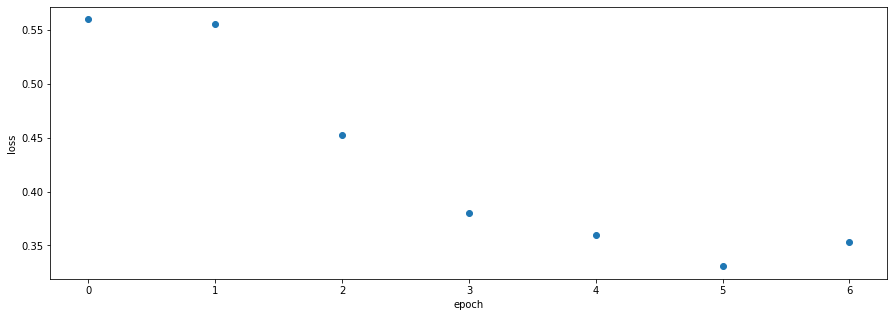

In [17]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

In [16]:
from opensoundscape.torch.models.cnn import load_model
model = load_model('./binary_train/best.model')

In [18]:
#create a copy of the training dataset, sampling 0 of the training samples from it
prediction_dataset = model.train_dataset.sample(n=0)
#turn off augmentation on this dataset
prediction_dataset.augmentation_off()
#use the validation samples as test samples for the sake of illustration
prediction_dataset.df = test_df

In [19]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset, binary_preds='single_target')
valid_preds_df

(138, 2)


,non-empty,empty
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile433.wav,1.0,0.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile024.wav,1.0,0.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile190.wav,1.0,0.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile048.wav,1.0,0.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile365.wav,1.0,0.0
...,...,...
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile483.wav,1.0,0.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile364.wav,1.0,0.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile380.wav,1.0,0.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile263.wav,1.0,0.0


In [20]:
valid_labels_df

,non-empty,empty
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile433.wav,1,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile024.wav,1,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile190.wav,1,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile048.wav,1,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile365.wav,1,0
...,...,...
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile483.wav,1,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile364.wav,1,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile380.wav,1,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile263.wav,1,0


In [27]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       123
           1       0.56      0.67      0.61        15

   micro avg       0.91      0.91      0.91       138
   macro avg       0.76      0.80      0.78       138
weighted avg       0.91      0.91      0.91       138
 samples avg       0.91      0.91      0.91       138



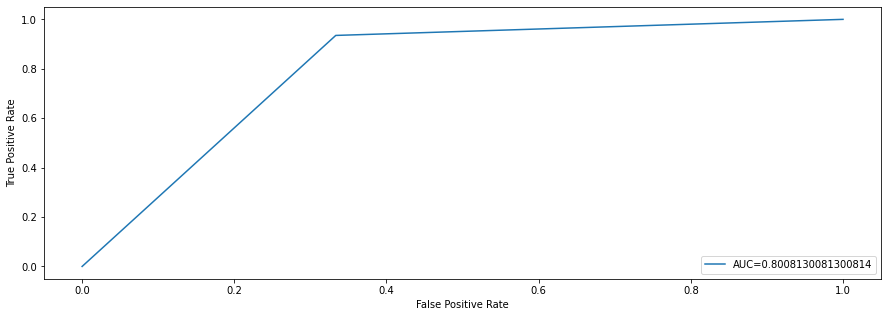

In [28]:
fpr, tpr, _ = roc_curve(valid_labels_df['non-empty'],  valid_preds_df['non-empty'])
auc = roc_auc_score(valid_labels_df['non-empty'],  valid_preds_df['non-empty'])

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## K-class classification

In [ ]:
kf = df.set_index('Filename').iloc[:, : 10]
kf.head()

In [ ]:
kf = kf[kf['Empty'] == 0]
kf = kf.drop('Empty', 1)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(kf, test_size=0.2, random_state=1)

train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=1)

In [ ]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df, overlay_df=train_df)

valid_dataset = CnnPreprocessor(valid_df, overlay_df=valid_df, return_labels=True)

In [ ]:
arch = cnn_architectures.resnet50(num_classes=len(list(kf.columns)))
model = cnn.PytorchModel(arch,list(kf.columns))

In [ ]:
model.optimizer_params['lr'] = 1e-4
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./first_10_train/',
    epochs=12,
    batch_size=64,
    save_interval=100,
    num_workers=0,
)

In [ ]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

score_df, pred_df, label_df = model.predict(
    prediction_dataset,
    binary_preds='multi_target',
    threshold = 0.3
)
pred_df

In [ ]:
for c in pred_df.columns:
    print("---- %s ---" % c)
    print(pred_df[c].value_counts())

In [ ]:
score_df

In [ ]:
label_df

## Multi-class classification

In [26]:
df.set_index('Filename', inplace=True)
df.head()

,Empty,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,...,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
Filename,,,,,,,,,,,,,,,,,,,,,
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile001.wav,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile002.wav,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile003.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile004.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile005.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [27]:
df = df[df['Empty'] == 0]
df = df.drop('Empty', 1)
df

/var/folders/km/7_v861mx0cb9fp42nvllkmt00000gn/T/ipykernel_2118/1487206957.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('Empty', 1)


,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,Cerbra_song,...,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
Filename,,,,,,,,,,,,,,,,,,,,,
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile001.wav,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile002.wav,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile003.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile004.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile005.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile683.wav,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile684.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile685.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [28]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)

train_df, valid_df = train_test_split(train_df, test_size=0.25, random_state=1)
# train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)

In [29]:
from opensoundscape.preprocess.preprocessors import CnnPreprocessor

train_dataset = CnnPreprocessor(train_df, overlay_df=train_df)

valid_dataset = CnnPreprocessor(valid_df, overlay_df=valid_df, return_labels=True)

In [30]:
train_df

,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,Cerbra_song,...,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
Filename,,,,,,,,,,,,,,,,,,,,,
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile210.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile335.wav,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile134.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile075.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile665.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile246.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile128.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile542.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
train_dataset.pipeline

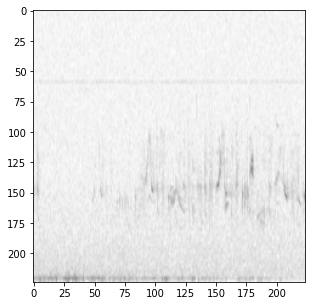

In [32]:
train_dataset.augmentation_off()
for i, d in enumerate(train_dataset.sample(n=1)):
    # print(f"labels: {d['y']}")
    show_tensor(d)
#turn augmentation back on when we're done
train_dataset.augmentation_on()

In [33]:
print(df.columns)
arch = cnn_architectures.resnet50(num_classes=len(list(df.columns)))
model = cnn.PytorchModel(arch,list(df.columns))

Index(['Aegcau_call', 'Alaarv_song', 'Anttri_song', 'Butbut_call',
       'Carcan_call', 'Carcan_song', 'Carcar_call', 'Carcar_song',
       'Cerbra_call', 'Cerbra_song', 'Cetcet_song', 'Chlchl_call',
       'Cicatr_song', 'Cicorn_song', 'Cisjun_song', 'Colpal_song',
       'Corcor_call', 'Denmaj_call', 'Denmaj_drum', 'Embcir_call',
       'Embcir_song', 'Erirub_call', 'Erirub_song', 'Fricoe_call',
       'Fricoe_song', 'Galcri_call', 'Galcri_song', 'Galthe_call',
       'Galthe_song', 'Gargla_call', 'Hirrus_call', 'Jyntor_song',
       'Lopcri_call', 'Loxcur_call', 'Lularb_song', 'Lusmeg_call',
       'Lusmeg_song', 'Lyrple_song', 'Motcin_call', 'Musstr_call',
       'Oriori_call', 'Oriori_song', 'Parate_call', 'Parate_song',
       'Parcae_call', 'Parcae_song', 'Parmaj_call', 'Parmaj_song',
       'Pasdom_call', 'Pelgra_call', 'Petpet_call', 'Petpet_song',
       'Phofem_song', 'Phycol_call', 'Phycol_song', 'Picpic_call',
       'Plaaff_song', 'Plasab_song', 'Poepal_call', 'Poepal_so

In [34]:
model.optimizer_params

{'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005}

In [35]:
model.optimizer_params['lr'] = 1e-4

In [36]:
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./multiclass_train/',
    epochs=12,
    batch_size=64,
    save_interval=100,
    num_workers=2,
)

Epoch: 0 [batch 0/6 (0.00%)] 
	Jacc: 0.023 Hamm: 0.977 DistLoss: 0.716

Validation.
(118, 87)
	 Precision: 0.021722189752581333
	 Recall: 0.9195402298850575
	 F1: 0.04221239517782729
Updating best model
Epoch: 1 [batch 0/6 (0.00%)] 
	Jacc: 0.023 Hamm: 0.977 DistLoss: 0.714

Validation.
(118, 87)
	 Precision: 0.021722189752581333
	 Recall: 0.9195402298850575
	 F1: 0.04221239517782729
Epoch: 2 [batch 0/6 (0.00%)] 
	Jacc: 0.022 Hamm: 0.978 DistLoss: 0.710

Validation.
(118, 87)
	 Precision: 0.021747070618764963
	 Recall: 0.9195402298850575
	 F1: 0.04225822140416372
Updating best model
Epoch: 3 [batch 0/6 (0.00%)] 
	Jacc: 0.024 Hamm: 0.976 DistLoss: 0.704

Validation.
(118, 87)
	 Precision: 0.021747070618764963
	 Recall: 0.9195402298850575
	 F1: 0.04225822140416372
Epoch: 4 [batch 0/6 (0.00%)] 
	Jacc: 0.026 Hamm: 0.974 DistLoss: 0.698

Validation.
(118, 87)
	 Precision: 0.02168310138153552
	 Recall: 0.9172413793103448
	 F1: 0.0421330781940532
Epoch: 5 [batch 0/6 (0.00%)] 
	Jacc: 0.023 Hamm

Text(0, 0.5, 'loss')

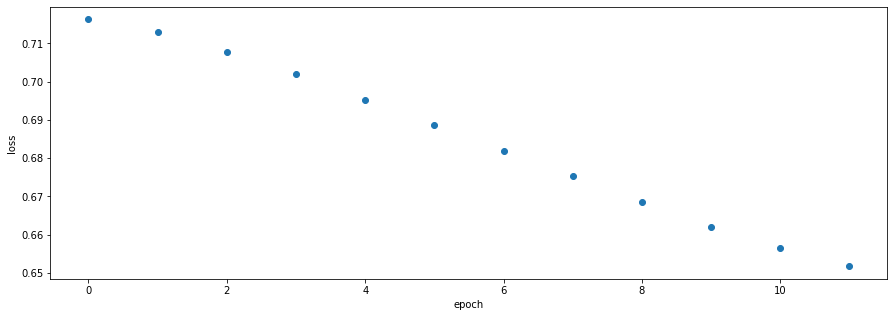

In [38]:
plt.scatter(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('epoch')
plt.ylabel('loss')

In [23]:
from opensoundscape.torch.models.cnn import load_model
model = load_model('./multiclass_train/best.model')

In [39]:
# create a Preprocessor instance with the audio samples
# use the model.train_dataset as a starting point to ensure that our preprocessing matches what the model expects
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

In [40]:
score_df, pred_df, label_df = model.predict(
    prediction_dataset,
    binary_preds='multi_target',
)
pred_df.head() # prediction made based on threshold

(118, 87)


,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,Cerbra_song,...,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile680.wav,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile331.wav,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile026.wav,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile584.wav,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile645.wav,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [41]:
score_df # scores assigned to each class

,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,Cerbra_song,...,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile680.wav,-0.411016,0.099587,0.352621,0.307858,-0.342380,-0.523921,-0.135332,0.386081,-0.019818,-0.168925,...,-0.419136,-0.372228,1.101510,0.172734,-0.172320,-0.404828,-0.413721,-0.160434,0.212192,0.660372
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile331.wav,-0.513241,0.019654,0.568858,0.410221,-0.406131,-0.423844,-0.247980,-0.014193,0.051476,-0.430077,...,-0.454917,-0.332591,0.727460,0.160095,0.384799,-0.699676,-0.538410,-0.126082,0.148337,0.550298
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile026.wav,-0.340787,0.205650,0.381542,0.624161,-0.298165,-0.617078,-0.297064,-0.106126,0.228001,-0.182947,...,-0.068258,-0.361863,0.993243,-0.027185,0.402419,-0.533113,-0.358545,-0.325411,0.205778,0.707806
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile584.wav,-0.192145,0.001499,0.385047,0.292938,-0.641355,-0.854355,-0.286309,0.096555,0.144848,-0.226100,...,-0.308607,-0.215340,0.684252,0.152840,0.253080,-0.801813,-0.537687,-0.259381,0.293650,0.358007
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile645.wav,-0.170873,0.373687,0.228038,0.640127,-0.192248,-0.602395,-0.020472,0.048393,0.080294,-0.323875,...,-0.677835,-0.202561,0.851421,-0.071799,0.360073,-0.769522,-0.604571,-0.397672,0.459937,0.861481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile666.wav,-0.301022,-0.031003,0.302792,0.546155,-0.402721,-0.673336,-0.271055,0.121675,0.243941,-0.317053,...,-0.399287,-0.210659,0.818635,-0.062842,0.549161,-0.680957,-0.396734,-0.354225,0.302970,0.595601
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile040.wav,-0.057478,0.516292,0.310548,0.313041,-0.207016,-0.391184,-0.091095,-0.034545,-0.066507,-0.317364,...,-0.492493,-0.425774,0.564470,-0.117766,0.150544,-0.516705,-0.316262,-0.128695,0.131043,0.489766
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile078.wav,-0.479221,0.263687,0.070896,0.519176,-0.235115,-0.348800,-0.194111,0.020411,-0.311183,-0.261908,...,-0.398476,-0.355596,0.815468,-0.075462,-0.173855,-0.427798,-0.470832,-0.645676,0.388549,0.601784
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile045.wav,-0.516212,0.140752,0.147710,0.218567,-0.314106,-0.490164,-0.261834,-0.106829,0.007953,-0.234209,...,-0.587638,-0.497813,0.749699,0.051481,0.054942,-0.555275,-0.412642,-0.288250,0.411714,0.610859


In [42]:
label_df # labels from the dataset

,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,Cerbra_song,...,Sylmel_song,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile680.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile331.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile026.wav,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile584.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile645.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile666.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile040.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile078.wav,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
./NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV/train/nips4b_birds_trainfile045.wav,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
print(classification_report(label_df, pred_df, target_names = label_df.columns))

              precision    recall  f1-score   support

 Aegcau_call       0.00      0.00      0.00         2
 Alaarv_song       0.02      0.67      0.04         3
 Anttri_song       0.03      1.00      0.05         3
 Butbut_call       0.04      1.00      0.08         5
 Carcan_call       0.00      0.00      0.00         3
 Carcan_song       0.00      0.00      0.00         7
 Carcar_call       0.00      0.00      0.00         3
 Carcar_song       0.02      0.67      0.05         3
 Cerbra_call       0.03      0.50      0.06         4
 Cerbra_song       0.00      0.00      0.00         2
 Cetcet_song       0.00      0.00      0.00         6
 Chlchl_call       0.01      0.20      0.03         5
 Cicatr_song       0.01      0.50      0.02         2
 Cicorn_song       0.00      0.00      0.00         1
 Cisjun_song       0.00      0.00      0.00         0
 Colpal_song       0.02      1.00      0.03         1
 Corcor_call       0.01      1.00      0.02         1
 Denmaj_call       0.00    

/Users/kushagraagrawal/anaconda3/envs/opso/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushagraagrawal/anaconda3/envs/opso/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Custom PyTorch model

In [37]:
import torch
import torch.nn as nn
from torch import cat